# Loading Dataset from Minio

In [9]:
import boto3
import os
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from prophet import Prophet

if data versioning is applied, use the code below:
<code>
version_id = 'your-version-id-here'
s3_client.download_file(bucket_name, object_name, '/home/jovyan/work/nvidia_stock_prices.csv', ExtraArgs={"VersionId": version_id})</code>


In [10]:
# Set up MinIO client
minio_endpoint = os.getenv('MINIO_ENDPOINT')
minio_access_key = os.getenv('MINIO_ACCESS_KEY')
minio_secret_key = os.getenv('MINIO_SECRET_KEY')

s3_client = boto3.client(
    's3',
    endpoint_url=minio_endpoint,
    aws_access_key_id=minio_access_key,
    aws_secret_access_key=minio_secret_key
)

# Define bucket name and object name
bucket_name = 'stocks'
object_name = 'nvidia_stock_prices.csv'

# Download the CSV file
s3_client.download_file(bucket_name, object_name, '/home/jovyan/work/nvidia_stock_prices.csv')

# Read the CSV file into a pandas DataFrame
data = pd.read_csv('/home/jovyan/work/nvidia_stock_prices.csv')
print(data.head(10))

         Date      Open      High       Low     Close      Volume
0  2004-01-02  0.196417  0.199083  0.192333  0.192333   436416000
1  2004-01-05  0.195250  0.199917  0.193500  0.198583   575292000
2  2004-01-06  0.198000  0.209417  0.197083  0.206667  1093344000
3  2004-01-07  0.204333  0.209500  0.202917  0.208500   673032000
4  2004-01-08  0.211083  0.212083  0.207250  0.209250   433752000
5  2004-01-09  0.207833  0.214833  0.206167  0.212250   766584000
6  2004-01-12  0.213000  0.215333  0.211000  0.214667   541980000
7  2004-01-13  0.213583  0.215667  0.201333  0.203583   865800000
8  2004-01-14  0.204583  0.207500  0.200167  0.202083   544872000
9  2004-01-15  0.200583  0.204083  0.197000  0.202417   609204000


# Data Preprocessing

In this experiment we only use one feature which is the "Close"
- (**Suggestions**) we could add more features such as Volume and Open to increase the accuracy of the prediction

In [3]:
# Ensure Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Renaming the necessary columns 
data = data.rename(columns={'Date': 'ds', 'Close': 'y'})

# Keep only the necessary columns 
data = data[['ds', 'y']]

data.head(5)

,ds,y
0,2004-01-02,0.192333
1,2004-01-05,0.198583
2,2004-01-06,0.206667
3,2004-01-07,0.208500
4,2004-01-08,0.209250


# MLflow Experiment

In this experiment we use GridSearch for autotuning the hyperparameter and use MSE (Mean Squared Error) for performance metric. The result of the experiment will be saved in bucket "mlflow" in minio that will contains 2 plots (main and component plots).
- (**Suggestions**) To evaluate the performance of the model further, we could apply other metrics such as R-Squared and MAE (Mean Absolute Error) 

In [4]:
def tune_prophet_hyperparameters(data, params_grid):
    best_params = None
    best_mse = float('inf')

    for params in ParameterGrid(params_grid):
        model = Prophet(**params)
        model.fit(data)

        # Create future dataframe for predictions
        future = model.make_future_dataframe(periods=0)  # Predict only for training data
        forecast = model.predict(future)

        # Calculate MSE on the training set
        current_mse = mean_squared_error(data['y'], forecast['yhat'])

        if current_mse < best_mse:
            best_params = params.copy()
            best_mse = current_mse

    return best_params, best_mse

In [5]:
# Define hyperparameter grid
params_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0]
}

In [7]:
# It tells Jupyter notebook to connect to the MLflow server using the Docker Compose service name
mlflow.set_tracking_uri('http://mlflow-web:5000')

# Set up the experiment name in the MLflow
experiment_name = "experiment_nvidia_prophet"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='s3://mlflow/1', creation_time=1735011547908, experiment_id='1', last_update_time=1735011547908, lifecycle_stage='active', name='experiment_nvidia_prophet', tags={}>

03:51:20 - cmdstanpy - INFO - Chain [1] start processing
03:51:21 - cmdstanpy - INFO - Chain [1] done processing
03:51:22 - cmdstanpy - INFO - Chain [1] start processing
03:51:22 - cmdstanpy - INFO - Chain [1] done processing
03:51:23 - cmdstanpy - INFO - Chain [1] start processing
03:51:24 - cmdstanpy - INFO - Chain [1] done processing
03:51:25 - cmdstanpy - INFO - Chain [1] start processing
03:51:25 - cmdstanpy - INFO - Chain [1] done processing
03:51:27 - cmdstanpy - INFO - Chain [1] start processing
03:51:27 - cmdstanpy - INFO - Chain [1] done processing
03:51:28 - cmdstanpy - INFO - Chain [1] start processing
03:51:29 - cmdstanpy - INFO - Chain [1] done processing
03:51:30 - cmdstanpy - INFO - Chain [1] start processing
03:51:31 - cmdstanpy - INFO - Chain [1] done processing
03:51:32 - cmdstanpy - INFO - Chain [1] start processing
03:51:33 - cmdstanpy - INFO - Chain [1] done processing
03:51:35 - cmdstanpy - INFO - Chain [1] start processing
03:51:36 - cmdstanpy - INFO - Chain [1]

🏃 View run clean-dolphin-442 at: http://mlflow-web:5000/#/experiments/1/runs/06067e2f581c49b9b9944f01d11aace8
🧪 View experiment at: http://mlflow-web:5000/#/experiments/1


S3UploadFailedError: Failed to upload predict/forecast_plot.png to mlflow/1/06067e2f581c49b9b9944f01d11aace8/artifacts/forecast_plot.png: An error occurred (NoSuchBucket) when calling the PutObject operation: The specified bucket does not exist

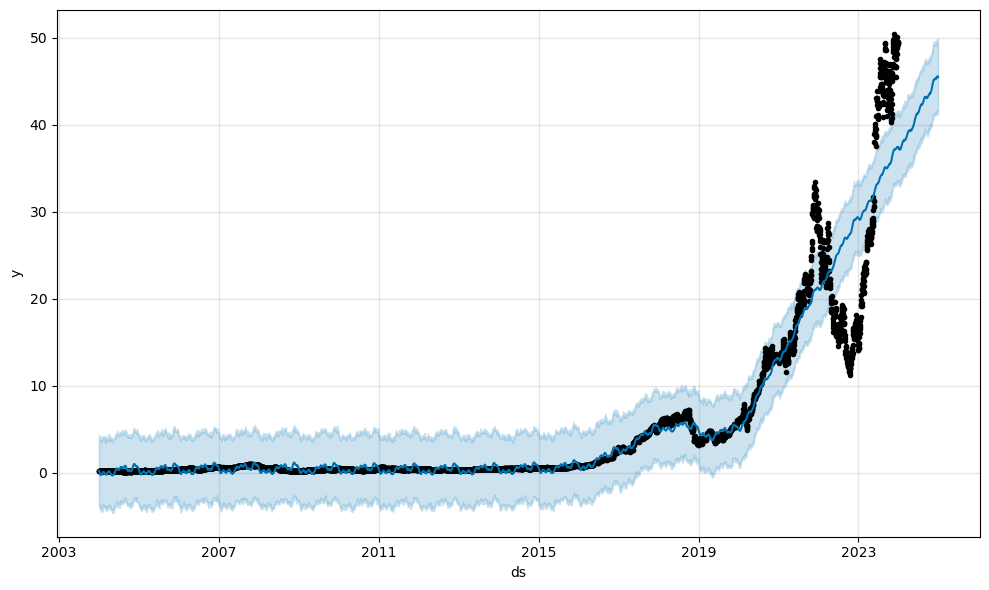

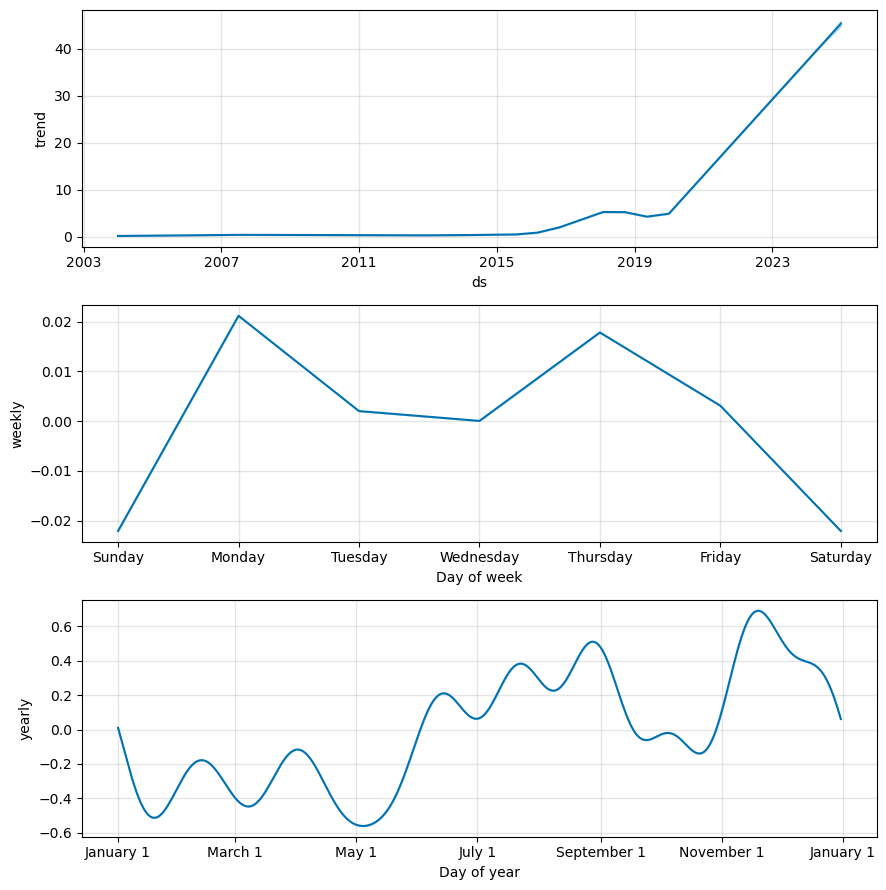

In [13]:
# Start an MLflow run
with mlflow.start_run():
    # Find the best hyperparameters and best MSE
    best_hyperparams, best_mse = tune_prophet_hyperparameters(data, params_grid)

    # Train the final model with the best hyperparameters
    final_model = Prophet(**best_hyperparams)
    final_model.fit(data)

    # Make future predictions
    future = final_model.make_future_dataframe(periods=365)
    forecast = final_model.predict(future)

    # Save the main plot
    fig1 = final_model.plot(forecast)

    # Save the components plot
    fig2 = final_model.plot_components(forecast)

    # Log the best hyperparameters, best MSE, and plots to MLflow
    mlflow.log_params(best_hyperparams)
    mlflow.log_metric("best_mse", best_mse)
    mlflow.log_artifact('predict/forecast_plot.png')
    mlflow.log_artifact('predict/forecast_components.png')

    # Display success message
    print("Plots saved successfully.")

In [ ]:
# Print the best hyperparameters and best MSE
print("Best Hyperparameters:", best_hyperparams)
print("Best MSE:", best_mse)